In [1]:
## load packages

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
cc = pd.read_csv('../../datasets/PlayData/BankChurners.csv')

In [3]:
cc.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
## is there a difference in credit limit(DV) among the different levels of card category(IV)?

## Data Wrangling

Depending on the data that you've been given, it may need some wrangling! In this case, although you can run the actual ANOVA using the original data, you can't test the assumptions or run the post hocs unless the data is wrangled.

### Focusing on the Card Categories

The data only has four card categories and we only need at least 2 levels to our independent categorical variable - so we are good to go!

### Subsetting to Only the Variables Needed

You only want to keep the two variables you'll need in your test: Credit_Limit and Card_Category.

In [6]:
cc1 = cc[['Credit_Limit', 'Card_Category']]

In [7]:
cc1.head()

,Credit_Limit,Card_Category
0,12691.0,Blue
1,8256.0,Blue
2,3418.0,Blue
3,3313.0,Blue
4,4716.0,Blue


In [8]:
## make sure our dependent variable Credit_Limit is an integer (continuous)!

In [9]:
cc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Credit_Limit   10127 non-null  float64
 1   Card_Category  10127 non-null  object 
dtypes: float64(1), object(1)
memory usage: 158.4+ KB


In [12]:
## convert it to an integer
cc1.Credit_Limit = cc1.Credit_Limit.astype(int)
## warnings are fine

In [13]:
cc1.head()

,Credit_Limit,Card_Category
0,12691,Blue
1,8256,Blue
2,3418,Blue
3,3313,Blue
4,4716,Blue


## Recoding Card_Category to a Number

The post-hocs and assumptions won't take any string values, so you'll need to recode Card_Category as well:

In [14]:
cc1.Card_Category.value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [16]:
dict = {"Blue" : 0, "Silver" : 1, "Gold" : 2, "Platinum" : 3}

In [18]:
cc1['Card_Category'] = cc1.Card_Category.replace(dict)
## warnings are fine

C:\Users\nolan\AppData\Local\Temp/ipykernel_21716/148741747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc1['Card_Category'] = cc1.Card_Category.replace(dict)


In [19]:
cc1.head()

,Credit_Limit,Card_Category
0,12691,0
1,8256,0
2,3418,0
3,3313,0
4,4716,0


#### _if you recoded into a new variable, be sure to drop your original Card_Category variable_

## Test Assumptions

Before you go any further, it's important to test for assumptions. If the assumptions are not met for ANOVA, but you proceeded anyway, you run the risk of biasing your results.

### Normality

You only need to test for the normality of the dependent variable, since the IV is categorical.

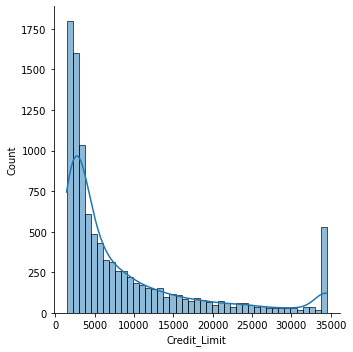

In [21]:
sns.displot(data=cc1, x="Credit_Limit", kde=True)
## not normal and definitely positively skewed

In [23]:
## let's try taking the square root, then run a log if it could still use some TLC in the name of normality
## let's just run both and compare

In [25]:
cc1['Credit_LimitSQRT'] = np.sqrt(cc1['Credit_Limit'])
## warnings are fine

C:\Users\nolan\AppData\Local\Temp/ipykernel_21716/3361506424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc1['Credit_LimitSQRT'] = np.sqrt(cc1['Credit_Limit'])


In [28]:
cc1['Credit_LimitLOG'] = np.log(cc1['Credit_Limit'])
## warnings are fine

C:\Users\nolan\AppData\Local\Temp/ipykernel_21716/1236190598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc1['Credit_LimitLOG'] = np.log(cc1['Credit_Limit'])


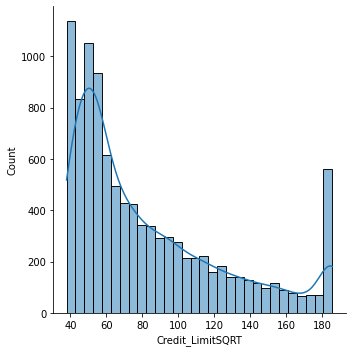

In [30]:
sns.displot(data=cc1, x="Credit_LimitSQRT", kde=True)
## looks a little better

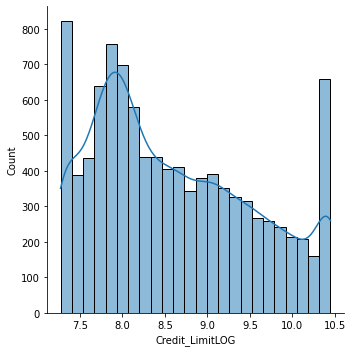

In [32]:
sns.displot(data=cc1, x="Credit_LimitLOG", kde=True)
## as approx. normally distributed as it is going to get

## Homogeneity of Variance

Just like in R, you can test for homogeneity of variance easily using either Bartlett's test or Fligner's Test. Bartlett's test is for when your data is normally distributed, and Fligner's test is for when your data is non-parametric. No matter which test you are using, you are looking for a non-significant test. The null hypothesis for both of these is that the data has equal variance, so you'd like to have a p value of > .05. Since you have corrected your data, you can use Bartlett's test, but just for learning purposes, you'll try both here.

## Bartlett's Test

To do Bartlett's test, use the function scipy.stats.bartlett(), with the argument of the y data, followed by the x data.